# Func Cluster Space (UMAP Analysis)

<div align="right">Last executed: 13-May-2022</div>

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from umap import UMAP

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from jupy_tools import plt_style
from jupy_tools import utils as u
from jupy_tools import cpa
from jupy_tools.utils import info

u.timestamp()

Timestamp: 04-Jul-2022 13:18:34


## Data Set of Cluster-Defining Compounds

In [2]:
# Full dataset, needed for joining the feature profiles
ds_refs = u.read_tsv("../output/ds_refs_sim_to_clusters.tsv")

# Cluster-defining dataset
ds_cluster = u.read_tsv("../input/cluster_cpds.tsv")[["Well_Id", "Cluster"]]
ds_cluster = pd.merge(ds_cluster, ds_refs, on="Well_Id", how="inner")
info(ds_cluster,"Profiles joined")


read_tsv                           : [    3560 / 601 ] 
read_tsv                           : [     227 /   5 ] ( Well_Id, Cluster, Induction, Conc_uM, Trivial_Name )
Profiles joined                    : [     227 / 602 ] 


Rename the clusters in the data set:

In [3]:
cluster_names = cpa.get_func_cluster_names()
cluster_names_dict = {
    'AKT_PI3K_MTOR': 'AKT/PI3K/MTOR',
    'Aurora': 'Aurora',
    'BET': 'BET',
    'DNA_Synth': 'DNA Synth',
    'HDAC': 'HDAC',
    'HSP90': 'HSP90',
    'LCH': 'LCH',
    'Protein_Synth': 'Protein Synth',
    'Tubulin': 'Tubulin',
    'Uncoupler': 'Uncoupling'
}

for cl in cluster_names:
    mask = ds_cluster["Cluster"] == cl
    ds_cluster.loc[mask, "Cluster"] = cluster_names_dict[cl]
ds_cluster[["Compound_Id", "Cluster"]].head()

,Compound_Id,Cluster
0,392483,AKT/PI3K/MTOR
1,392483,AKT/PI3K/MTOR
2,410607,AKT/PI3K/MTOR
3,392535,AKT/PI3K/MTOR
4,392538,AKT/PI3K/MTOR


### UMAP Analyis and Plot

In [4]:
colors = ["#e377c2", "#000000", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#c2d0e9", "#bcbd22", "#17becf", ]  # #bdbdbd
color_dict = {x: colors[idx] for idx, x in enumerate(cluster_names_dict.values())}
# color_dict[" 0. Not Assigned"] = colors[0]  # no undefined cluster in the cluster-defining compound dataset
color_dict

{'AKT/PI3K/MTOR': '#e377c2',
 'Aurora': '#000000',
 'BET': '#1f77b4',
 'DNA Synth': '#ff7f0e',
 'HDAC': '#2ca02c',
 'HSP90': '#d62728',
 'LCH': '#9467bd',
 'Protein Synth': '#8c564b',
 'Tubulin': '#c2d0e9',
 'Uncoupling': '#bcbd22'}

<Figure size 1080x1008 with 0 Axes>

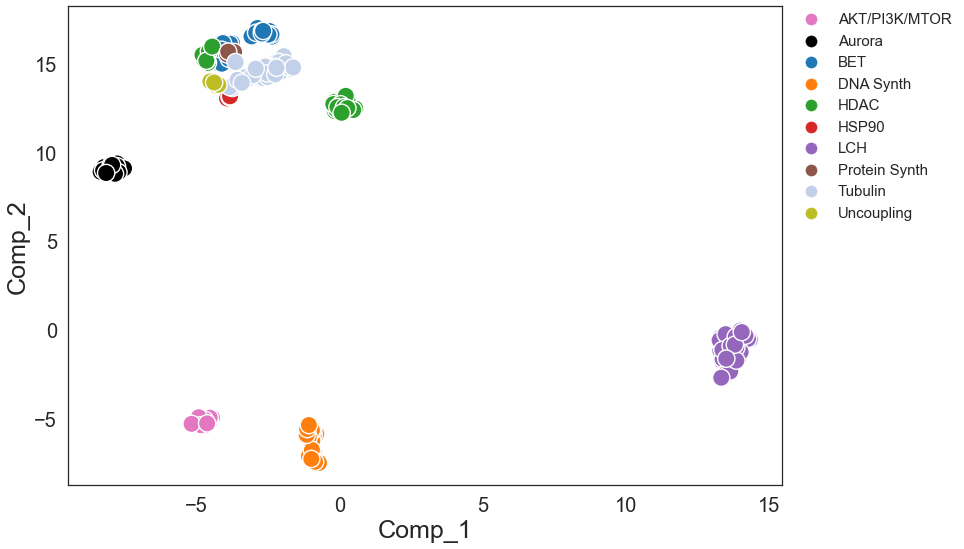

In [5]:
# Best result with 15 / False:
n_neighbors = 15
normalization = False

tmp_data = ds_cluster[cpa.ACT_PROF_FEATURES].copy()
tmp_data = np.clip(tmp_data, -25.0, 25.0)
if normalization:
    is_norm = "norm"
    df_data = minmax_scale(tmp_data, feature_range=(-1, 1), axis=1)
else:
    is_norm = "not_norm"
    df_data = tmp_data.copy()
columns = ["Well_Id", "Cluster", "Trivial_Name", "Known_Act", "Chiral", "Smiles"]
df_comp = ds_cluster[columns].copy()
reducer = UMAP(n_components=2, random_state=0xc0ffee, n_neighbors=n_neighbors)
reducer.fit(df_data)
umap_result = reducer.transform(df_data)
df_comp["Comp_1"] = umap_result[:, 0]
df_comp["Comp_2"] = umap_result[:, 1]
# df_comp["Comp_3"] = umap_result[:, 2]
df_comp = df_comp.sort_values("Cluster")
df_comp = df_comp[["Well_Id", "Comp_1", "Comp_2", "Cluster", "Trivial_Name", "Known_Act", "Chiral", "Smiles"]]
# Saving for DataWarrior:
u.write_tsv(df_comp, f"../output/ds_cluster_cpds_umap_nb_{n_neighbors}_{is_norm}_dw.txt")

plt.figure(figsize=(15, 14));
fig, ax = plt.subplots();
splot = sns.scatterplot(
    data=df_comp, 
    x="Comp_1", y="Comp_2", hue="Cluster", s=300,
    palette=color_dict
    # palette=colors.values()
)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
fig.savefig(f"plots/ds_cluster_cpds_scatter_umap_nb_{n_neighbors}_{is_norm}.png", bbox_inches='tight');
fig.savefig(f"plots/ds_cluster_cpds_scatter_umap_nb_{n_neighbors}_{is_norm}.svg", bbox_inches='tight');